RMC ANALİZİ:
Platform hızı: 100 m/s
Hedef mesafesi: 250 m
Range çözünürlüğü: 0.75 m
Max mesafe kayması: 8.06 m
Kaç hücre kayıyor: 10.7
RMC gerekli mi? EVET ✓


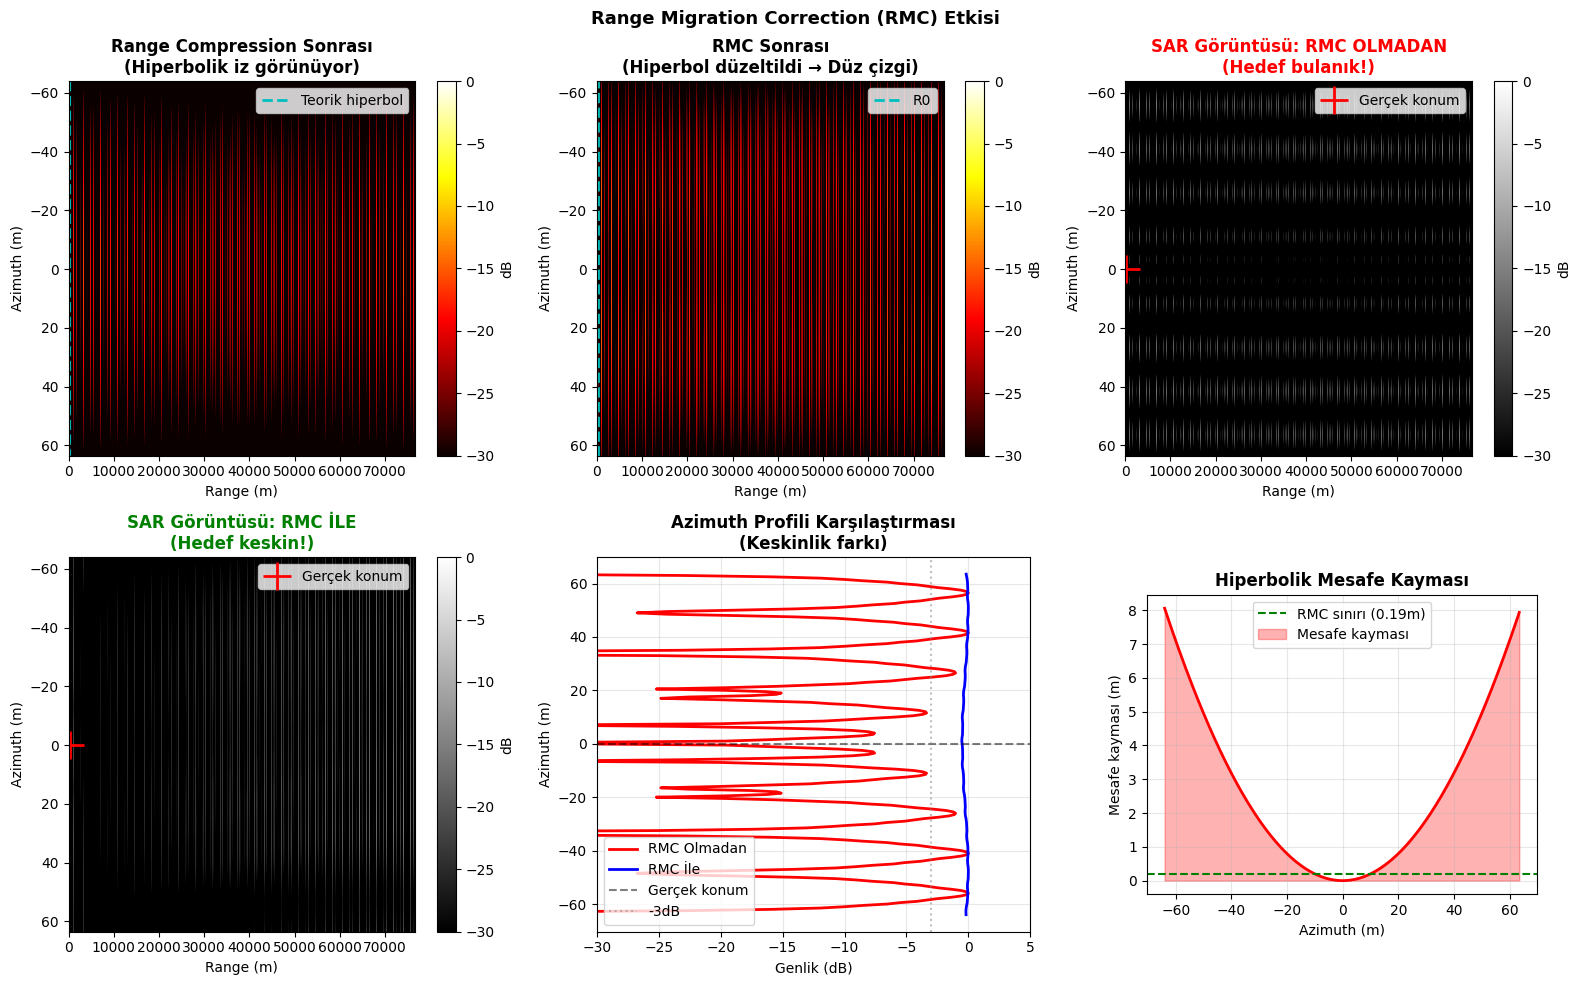


ÖZET:
Max mesafe kayması:  8.06 m
Range çözünürlüğü:  0.75 m
RMC olmadan:        Hedef bulanık
RMC ile:            Hedef keskin


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ============================================
# PARAMETRELER
# ============================================
c = 3e8
f_c = 10e9
lambda_c = c / f_c
B = 200e6
T_chirp = 1e-3
K = B / T_chirp
fs = 1e6
N_range = 512
N_azimuth = 256
v = 100            # Hızı artırdık → RMC etkisi daha belirgin

t_range = np.arange(N_range) / fs
range_axis = np.arange(N_range) * c / (2 * fs)

PRF = 200
t_az = np.arange(N_azimuth) / PRF
y_platform = v * t_az - v * N_azimuth / (2 * PRF)

# Tek hedef (RMC etkisini net görmek için)
target = {'range': 250, 'azimuth': 0, 'amp': 1.0}

R0 = target['range']
Ka = 2 * v**2 / (lambda_c * R0)

# Mesafe kayması hesapla
R_instant_all = np.sqrt(R0**2 + y_platform**2)
delta_R_max = (R_instant_all - R0).max()
range_res = c / (2 * B)

print("="*55)
print("RMC ANALİZİ:")
print("="*55)
print(f"Platform hızı: {v} m/s")
print(f"Hedef mesafesi: {R0} m")
print(f"Range çözünürlüğü: {range_res:.2f} m")
print(f"Max mesafe kayması: {delta_R_max:.2f} m")
print(f"Kaç hücre kayıyor: {delta_R_max/range_res:.1f}")
print(f"RMC gerekli mi? {'EVET ✓' if delta_R_max > range_res/4 else 'HAYIR ✗'}")
print("="*55)

# ============================================
# HAM VERİ OLUŞTUR
# ============================================
ref_chirp = np.exp(1j * np.pi * K * t_range**2)
raw_data = np.zeros((N_azimuth, N_range), dtype=complex)

for az_idx, yp in enumerate(y_platform):
    R_instant = np.sqrt(R0**2 + (yp - target['azimuth'])**2)
    delay = 2 * R_instant / c
    delay_samples = int(delay * fs)

    angle = np.arctan2(yp - target['azimuth'], R0)
    beamwidth = lambda_c / 0.1
    weight = np.sinc(angle / beamwidth)

    if delay_samples < N_range:
        delayed = np.zeros(N_range, dtype=complex)
        delayed[delay_samples:] = ref_chirp[:N_range - delay_samples]
        raw_data[az_idx] += weight * delayed

# ============================================
# ADIM 1: RANGE COMPRESSION
# ============================================
H_range = np.fft.fft(ref_chirp)
range_compressed = np.zeros_like(raw_data)

for az_idx in range(N_azimuth):
    S = np.fft.fft(raw_data[az_idx])
    range_compressed[az_idx] = np.fft.ifft(S * np.conj(H_range))

# ============================================
# ADIM 2A: RMC OLMADAN azimuth compression
# ============================================
sar_no_rmc = np.zeros_like(range_compressed)
h_az = np.exp(-1j * np.pi * Ka * t_az**2)
H_az = np.fft.fft(h_az)

for range_idx in range(N_range):
    R_cell = range_axis[range_idx]
    if R_cell < 1:
        continue
    column = range_compressed[:, range_idx]
    S_az = np.fft.fft(column)
    sar_no_rmc[:, range_idx] = np.fft.ifft(S_az * np.conj(H_az))

# ============================================
# ADIM 2B: RMC UYGULA (Time Domain Interpolasyon)
# ============================================
rmc_data = np.zeros_like(range_compressed)

for az_idx, yp in enumerate(y_platform):
    # Bu azimuth pozisyonunda mesafe kayması
    R_inst = np.sqrt(R0**2 + yp**2)
    delta_R = R_inst - R0

    # Her range örneğini delta_R kadar kaydır
    shift_samples = delta_R / (c / (2 * fs))

    # İnterpolasyon ile kaydırma
    original_indices = np.arange(N_range)
    shifted_indices = original_indices + shift_samples

    # Gerçek ve sanal kısımları ayrı interpolate et
    f_real = interp1d(shifted_indices,
                      np.real(range_compressed[az_idx]),
                      bounds_error=False, fill_value=0)
    f_imag = interp1d(shifted_indices,
                      np.imag(range_compressed[az_idx]),
                      bounds_error=False, fill_value=0)

    rmc_data[az_idx] = f_real(original_indices) + 1j * f_imag(original_indices)

# ============================================
# ADIM 2C: RMC SONRASI azimuth compression
# ============================================
sar_with_rmc = np.zeros_like(rmc_data)

for range_idx in range(N_range):
    R_cell = range_axis[range_idx]
    if R_cell < 1:
        continue

    Ka_cell = 2 * v**2 / (lambda_c * R_cell)
    h_az_cell = np.exp(-1j * np.pi * Ka_cell * t_az**2)
    H_az_cell = np.fft.fft(h_az_cell)

    column = rmc_data[:, range_idx]
    S_az = np.fft.fft(column)
    sar_with_rmc[:, range_idx] = np.fft.ifft(S_az * np.conj(H_az_cell))

# ============================================
# GÖRSELLEŞTİRME
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Range compressed (hiperbolik iz)
ax = axes[0, 0]
rc_db = 20*np.log10(np.abs(range_compressed)+1e-10)
rc_db -= rc_db.max()
im = ax.imshow(rc_db, aspect='auto', cmap='hot',
               vmin=-30, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      y_platform[-1], y_platform[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('Range Compression Sonrası\n(Hiperbolik iz görünüyor)',
             fontweight='bold')

# Teorik hiperbol çiz
R_hyp = np.sqrt(R0**2 + y_platform**2)
ax.plot(R_hyp, y_platform, 'c--', linewidth=2, label='Teorik hiperbol')
ax.legend()

# 2. RMC sonrası (düzeltilmiş)
ax = axes[0, 1]
rmc_db = 20*np.log10(np.abs(rmc_data)+1e-10)
rmc_db -= rmc_db.max()
im = ax.imshow(rmc_db, aspect='auto', cmap='hot',
               vmin=-30, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      y_platform[-1], y_platform[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.axvline(R0, color='c', linestyle='--', linewidth=2, label='R0')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('RMC Sonrası\n(Hiperbol düzeltildi → Düz çizgi)',
             fontweight='bold')
ax.legend()

# 3. RMC olmadan SAR görüntüsü
ax = axes[0, 2]
no_rmc_db = 20*np.log10(np.abs(sar_no_rmc)+1e-10)
no_rmc_db -= no_rmc_db.max()
im = ax.imshow(no_rmc_db, aspect='auto', cmap='gray',
               vmin=-30, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      y_platform[-1], y_platform[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.plot(target['range'], target['azimuth'],
        'r+', markersize=20, markeredgewidth=2, label='Gerçek konum')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('SAR Görüntüsü: RMC OLMADAN\n(Hedef bulanık!)',
             fontweight='bold', color='red')
ax.legend()

# 4. RMC ile SAR görüntüsü
ax = axes[1, 0]
rmc_sar_db = 20*np.log10(np.abs(sar_with_rmc)+1e-10)
rmc_sar_db -= rmc_sar_db.max()
im = ax.imshow(rmc_sar_db, aspect='auto', cmap='gray',
               vmin=-30, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      y_platform[-1], y_platform[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.plot(target['range'], target['azimuth'],
        'r+', markersize=20, markeredgewidth=2, label='Gerçek konum')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('SAR Görüntüsü: RMC İLE\n(Hedef keskin!)',
             fontweight='bold', color='green')
ax.legend()

# 5. Azimuth profili karşılaştırması
ax = axes[1, 1]
r_idx = np.argmin(np.abs(range_axis - R0))
az_no_rmc = 20*np.log10(np.abs(sar_no_rmc[:, r_idx])+1e-10)
az_with_rmc = 20*np.log10(np.abs(sar_with_rmc[:, r_idx])+1e-10)
az_no_rmc -= az_no_rmc.max()
az_with_rmc -= az_with_rmc.max()

ax.plot(az_no_rmc, y_platform, 'r-', linewidth=2,
        label='RMC Olmadan')
ax.plot(az_with_rmc, y_platform, 'b-', linewidth=2,
        label='RMC İle')
ax.axhline(target['azimuth'], color='k', linestyle='--',
           alpha=0.5, label='Gerçek konum')
ax.axvline(-3, color='gray', linestyle=':', alpha=0.5, label='-3dB')
ax.set_xlabel('Genlik (dB)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('Azimuth Profili Karşılaştırması\n(Keskinlik farkı)',
             fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([-30, 5])

# 6. RMC etkisi özeti
ax = axes[1, 2]
ax.axis('off')

# Mesafe kayması grafiği
ax2 = ax.inset_axes([0.05, 0.1, 0.9, 0.8])
ax2.plot(y_platform, R_instant_all - R0, 'r-', linewidth=2)
ax2.axhline(range_res/4, color='g', linestyle='--',
            label=f'RMC sınırı ({range_res/4:.2f}m)')
ax2.fill_between(y_platform, 0, R_instant_all - R0,
                 alpha=0.3, color='red', label='Mesafe kayması')
ax2.set_xlabel('Azimuth (m)')
ax2.set_ylabel('Mesafe kayması (m)')
ax2.set_title('Hiperbolik Mesafe Kayması', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Range Migration Correction (RMC) Etkisi',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*55)
print("ÖZET:")
print("="*55)
print(f"Max mesafe kayması:  {delta_R_max:.2f} m")
print(f"Range çözünürlüğü:  {range_res:.2f} m")
print(f"RMC olmadan:        Hedef bulanık")
print(f"RMC ile:            Hedef keskin")
print("="*55)